# Preprocess observations

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join('../..')))  # access sibling directories

from src.python.helpers import area_grid
from src.python.settings import plotting_settings, plotting_update

import matplotlib.pyplot as plt
plt.rcParams.update(plotting_update)

import numpy as np
import pandas as pd
import xarray as xr

import subprocess
import shlex

2024-02-07 16:42:29.510838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ho/code/BayesFlow/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
RESOLUTION_LAT, RESOLUTION_LON = 72, 144

In [3]:
DIR = '/home/ho/code/climate/sim-data/'
berkeley_folder = 'berkeley-earth/'
filename_highres = 'Land_and_Ocean_LatLong_new2024.nc'
filename_out = 'observations-berkeley-new2024.nc'

# Coarsen observation data to the same grid as simulations
The Berkeley Earth Project provides monthly anomalies to the climatology of 1951 to 1980 on a 1°x1° global grid. 
We are interested in anomalies to the yearly climatology of the same time period and need a specific 2.5°x2.5° grid that matches the one we are using in simulated data.
For the regridding we use **conservative first order remapping** as implemented in [Climate Data Operators (CDO)](https://code.mpimet.mpg.de/projects/cdo).

In [4]:
raw_data_path = os.path.join(DIR, berkeley_folder, filename_highres)
role_model_grid_path = os.path.join(DIR, 'preproc', 'tas_anual_preproc_ssp126_ACCESS-ESM1-5.nc') # any model will do. They should all have the same grid.
preproc_lowres_path = os.path.join(DIR, berkeley_folder, 'berkeley_lowres.nc')

In [5]:
if os.path.exists(preproc_lowres_path):
    os.remove(preproc_lowres_path)
runText = f'cdo remapcon,{role_model_grid_path} {raw_data_path} {preproc_lowres_path}'
print(runText)
process = subprocess.Popen(shlex.split(runText), stdout=subprocess.PIPE)
output, error = process.communicate()
process.wait()

cdo remapcon,/home/ho/code/climate/sim-data/preproc/tas_anual_preproc_ssp126_ACCESS-ESM1-5.nc /home/ho/code/climate/sim-data/berkeley-earth/Land_and_Ocean_LatLong_new2024.nc /home/ho/code/climate/sim-data/berkeley-earth/berkeley_lowres.nc


Warning (cdf_check_variables): 5 dimensional variables are not supported, skipped variable TAS!
Warning (split_timevalue): Fraction of a year is not supported!!


0

In [6]:
ds = xr.open_dataset(preproc_lowres_path)

if False:
    ds_slice = ds.isel(time=slice(-55,None))
    slice_path = '../../../climate/sim-data/berkeley-earth/Land_and_Ocean_LatLong_slice.nc'
    os.remove(slice_path)
    ds_slice.to_netcdf(slice_path)


    raw_data_path = slice_path
    ds = xr.open_dataset(raw_data_path)
ds

<xarray.Dataset>
Dimensions:      (time: 2088, longitude: 144, latitude: 72, month_number: 12)
Coordinates:
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.023e+03 2.023e+03
  * longitude    (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude     (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 ...
    temperature  (time, latitude, longitude) float32 ...
    climatology  (month_number, latitude, longitude) float32 ...
Attributes:
    CDI:                   Climate Data Interface version 2.0.4 (https://mpim...
    institution:           Berkeley Earth Surface Temperature Project
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               Wed Feb 07 16:42:46 2024: cdo remapcon,/home/ho/co...
    land_source_history:   09-Jan-2024 16:13:29
    ocean_source_history:  09-Jan-2024 15:20:38
    comment:               This file contains Berkeley Earth surface temperat...
    CDO:                   Climate Data Operators version 2.0.4 (https://mpim...

In [7]:
# correct resolution?
assert ds.latitude.shape[0] == RESOLUTION_LAT
assert ds.longitude.shape[0] == RESOLUTION_LON

# Reshape dimension time (float) in years into dimensions year (int) and month_number (int)
This will let us add the monthly climatology to the temperature anomaly values. 

In [8]:
# extract year and month from time dimension
years = ds['time'].values.astype(int)
months = ((ds['time'].values - years) * 12).astype(int)

# confirm that the months will not be shifted by reshaping
assert np.unique(years[:12]) == years[0] # i.e. the dataset starts with a full year of 12 months

# reshape temperature anomaly data from (time, lat, lon) to (year, month, lat, lon)
tas_anom = ds.temperature.values
unique_years = np.unique(years)
num_years = len(unique_years)
tas_anom_padded = np.full((num_years*12, 72, 144), np.nan)
tas_anom_padded[:tas_anom.shape[0]] = tas_anom
tas_anom_reshaped = tas_anom_padded.reshape((num_years, 12, 72, 144))

# calculate absolute temperature from anomaly and climatology of 1951-1980
tas = tas_anom_reshaped + ds.climatology.values[None,:,:,:]

In [9]:
print(tas_anom.shape, '->', tas_anom_reshaped.shape)
print(tas_anom_reshaped.shape, '+', ds.climatology.values.shape, '->', tas.shape)

(2088, 72, 144) -> (174, 12, 72, 144)
(174, 12, 72, 144) + (12, 72, 144) -> (174, 12, 72, 144)


In [10]:
temp = xr.DataArray(
    tas,
    dims=['year', 'month_number', 'latitude', 'longitude'],
    coords={'latitude': ds.latitude, 'longitude': ds.longitude, 'year': unique_years, 'month_number':np.arange(12)},
    attrs={
            'long_name': 'surface_temperature',
            'description': 'Surface Air Temperature at Reference Height',
            'institution': 'Berkeley Earth Surface Temperature Project',
            'units': '°C',
        },
)

ds = ds.assign({'TAS': temp}) # add temperature data to dataset with name TAS (Temperature at Surface)

# confirm that the months were not shifted by reshaping
assert np.all(np.arange(12) == ds['month_number'].values)

ds = ds.drop(['temperature', 'time'])

In [11]:
ds.attrs={
    'description': 'Berkeley Earth Surface Temperature Project',
}
ds.TAS.attrs={
    'long_name': 'surface_temperature',
    'description': 'Absolute Surface Air Temperature measured in the Berkeley Earth Surface Temperature Project. ' + \
        'The original monthly anomaly (versus 1951-1980) on a 1º x 1º Latitude-Longitude grid from https://berkeleyearth.org/data/ ' + \
        'was converted anomalies to the yearly climatology on a 2.5°x2.5° grid.',
    'units': '°C',
}

In [12]:
# Calculate area of each grid cell
xda = area_grid(ds.latitude, ds.longitude)
ds = ds.assign({'AREA':xda})

In [13]:
# Calculate global mean temperature DataArray with correct area weighting
xgt = (ds.TAS * ds.AREA / ds.AREA.sum(dim=('latitude','longitude'))).sum(dim=('latitude','longitude'))
xgt.attrs = {
            'long_name': 'global_mean_surface_temperature',
            'description': 'Global Mean of Surface Air Temperature. Weighted by area of each grid cell.',
            'units': '°C'}
ds = ds.assign({'TAS_global': xgt})

In [14]:
# Calculate mean at each grid point, ignoring missing values
xt_baseline = ds.TAS.sel(year=slice(1951,1980)).mean(dim=('year', 'month_number'), skipna=True)
xt_baseline.attrs = {
            'long_name': 'mean_surface_temperature_baseline',
            'description': 'Mean of Surface Air Temperature for the period 1951 to 1980',
            'units': '°C'}
ds = ds.assign({'TAS_baseline': xt_baseline})

In [15]:
ds

<xarray.Dataset>
Dimensions:       (longitude: 144, latitude: 72, month_number: 12, year: 174)
Coordinates:
  * longitude     (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude      (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * month_number  (month_number) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2020 2021 2022 2023
Data variables:
    land_mask     (latitude, longitude) float64 ...
    climatology   (month_number, latitude, longitude) float32 -24.46 ... -30.49
    TAS           (year, month_number, latitude, longitude) float64 nan ... -...
    AREA          (latitude, longitude) float64 1.678e+09 ... 1.678e+09
    TAS_global    (year, month_number) float64 9.291 10.32 10.97 ... 14.64 13.91
    TAS_baseline  (latitude, longitude) float64 -46.5 -46.63 ... -19.87 -19.87
Attributes:
    description:  Berkeley Earth Surface Temperature Project

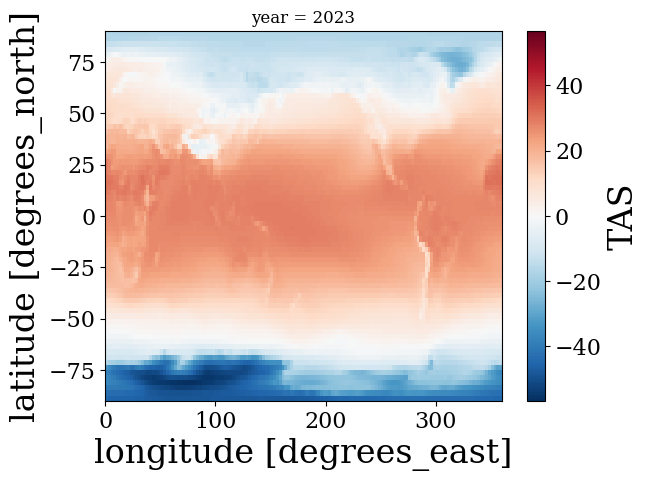

In [16]:
ds.isel(year=-1).TAS.mean(dim='month_number').plot()

# Missing values

In [17]:
# find out how many missing values there are per year
ds.TAS.isnull().sum(dim=['latitude', 'longitude']).sel(year=(ds.year>=1970))

<xarray.DataArray 'TAS' (year: 54, month_number: 12)>
array([[ 0,  0,  0,  0,  5,  0,  6,  0,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  2, 11, 15, 15,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 19, 19, 13, 14, 11,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  9, 18, 11,  8,  0],
       [ 0,  0,  0,  0,  6,  5, 21, 23, 43, 30, 22,  4],
       [ 0,  0,  0,  0,  2, 14, 24, 18, 20,  8,  7,  0],
       [ 0,  0,  0,  0, 14, 25, 53,  8, 18, 33, 23,  0],
       [ 0,  0,  0,  0,  0,  4, 14,  9, 13, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
...
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
Coordinates:
  * month_number  (month_number) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year          (year) int64 1970 1971 1972 1973 1974 ... 2020 2021 2022 2023

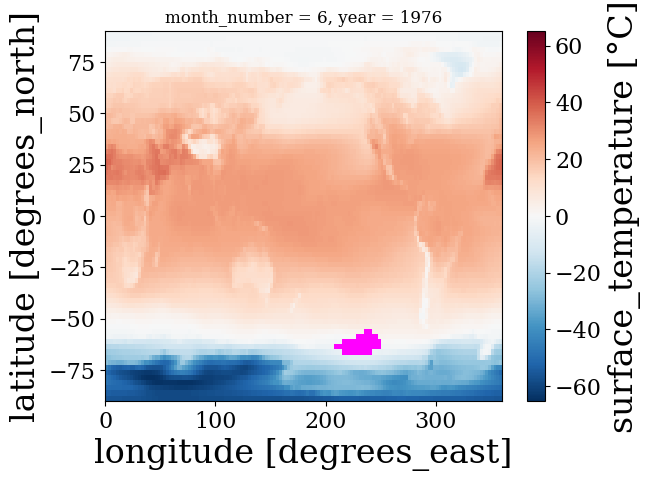

In [18]:
cmap = plt.cm.RdBu_r; cmap.set_bad('magenta')

ds.TAS.sel(year=1976, month_number=6).plot(cmap=cmap)   # missing values above antarctica are seen in magenta

The missing values are above antarctica in the pacific. After 1980 missing data is very sparse. Data from 1980 should be used with caution since the interpolation error is bound to be significant. Interpolations since 1980 however should be trustworthy.

We could interpolate linearly along latitudes. With the most recent Berkeley Earth data (September 2023) this is not necessary however.

In [19]:
interpolate = False
if interpolate:
    interpolated_tas = ds.sel(year=slice(1980, 2100)).TAS.interpolate_na(dim='latitude', method='linear', limit=1)

    # Update ds with the interpolated values
    ds['TAS'].loc[dict(year=slice(1980, 2100))] = interpolated_tas

    # inspect if observations since 1980 have no missing values anymore
    ds.TAS.isnull().sum(dim=['latitude', 'longitude']).sel(year=(ds.year>=1970))

# Save to disk

In [20]:
ds.to_netcdf(os.path.join(DIR, 'preproc', filename_out))

# How to load preprocessed observation data

In [22]:
X = xr.open_dataset(os.path.join(DIR, 'preproc', filename_out))
X

<xarray.Dataset>
Dimensions:       (longitude: 144, latitude: 72, month_number: 12, year: 174)
Coordinates:
  * longitude     (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude      (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * month_number  (month_number) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2020 2021 2022 2023
Data variables:
    land_mask     (latitude, longitude) float64 ...
    climatology   (month_number, latitude, longitude) float32 ...
    TAS           (year, month_number, latitude, longitude) float64 ...
    AREA          (latitude, longitude) float64 ...
    TAS_global    (year, month_number) float64 ...
    TAS_baseline  (latitude, longitude) float64 ...
Attributes:
    description:  Berkeley Earth Surface Temperature Project